In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
languages = ['merge2']
d ={}
b={}
for language in languages:
    d[language] =[]
    b[language]=[]

In [3]:
def plot_roc_curve(model, X_test, y_test, model_name, color):
    # Get the probability predictions for the positive class
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    print(f'Model:{model_name}, auc={roc_auc}')
    b[language].append(roc_auc)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

Random forest
[[163  33]
 [ 21 175]]
[[126  70]
 [ 58 138]]
              precision    recall  f1-score   support

         low       0.68      0.64      0.66       196
        high       0.66      0.70      0.68       196

    accuracy                           0.67       392
   macro avg       0.67      0.67      0.67       392
weighted avg       0.67      0.67      0.67       392

K_fold: [0.65909091 0.50574713 0.62068966 0.55172414 0.93103448 0.62068966
 0.3908046  0.52873563 0.49425287], 
mean=0.5891965633344944

DecisionTree
[[196   0]
 [  0 196]]
[[128  68]
 [ 74 122]]
              precision    recall  f1-score   support

         low       0.63      0.65      0.64       196
        high       0.64      0.62      0.63       196

    accuracy                           0.64       392
   macro avg       0.64      0.64      0.64       392
weighted avg       0.64      0.64      0.64       392

K_fold: [0.65909091 0.44827586 0.54022989 0.4137931  0.8045977  0.6091954
 0.51724138 0.52

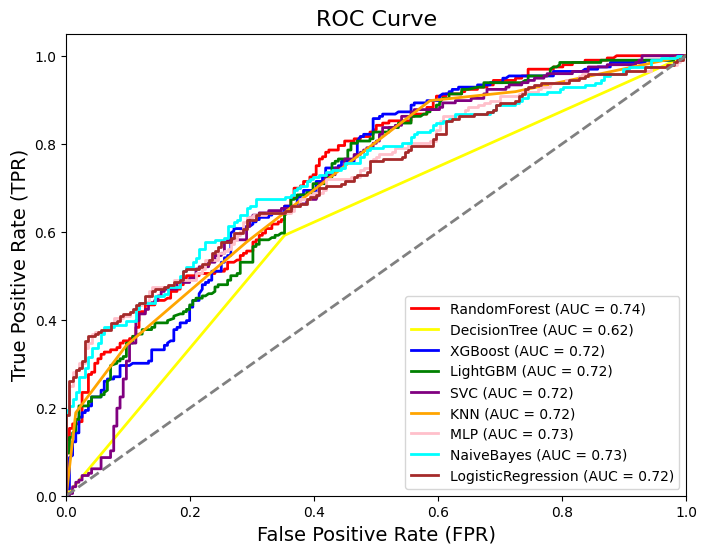

In [4]:
for language in languages:
    # print(language)
    df = pd.read_csv(f'data/normalized/language2/{language}.csv')
    labels=['low','high']

    df[f'tiobe_label'] = df[f'tiobe_label'].astype('category')
    df[f'tiobe_label_encoded'] = df[f'tiobe_label'].cat.codes
    X = df[[f'wiki', f'gtrend']]
    y = df[f'tiobe_label_encoded'] 

    stratified_cv = StratifiedKFold(n_splits=9)
    X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train1, y_train1)


    
    print("Random forest")
    # rf_model = RandomForestClassifier()
    rf_model = RandomForestClassifier(bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rf_cv_scores = cross_val_score(rf_model, X, y, cv=stratified_cv, scoring='accuracy') 
    rf_model.fit(X_train, y_train)
    y_pred_train = rf_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold: {rf_cv_scores}, \nmean={rf_cv_scores.mean()}")
    d[language].append(rf_cv_scores.mean())

    print()
    print("DecisionTree")
    dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter='random')
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    dt_cv_scores = cross_val_score(dt_model, X, y, cv=stratified_cv, scoring='accuracy') 
    dt_model.fit(X_train, y_train)
    y_pred_train = dt_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold: {dt_cv_scores}, \nmean: {dt_cv_scores.mean()}")
    d[language].append(dt_cv_scores.mean())


    print()
    print("Xgboost")
    # xgb_model = XGBClassifier()
    xgb_model = XGBClassifier(colsample_bytree=1.0, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=100, subsample=0.8)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=stratified_cv, scoring='accuracy') 
    xgb_model.fit(X_train, y_train)
    y_pred_train = xgb_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold: {xgb_cv_scores}, \nmean= {xgb_cv_scores.mean()}")
    d[language].append(xgb_cv_scores.mean())


    print()
    print("LightGBM")
    # lgb_model = LGBMClassifier()
    lgb_model = LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_samples=20, n_estimators=100, subsample=0.8)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    lgb_cv_scores = cross_val_score(lgb_model, X, y, cv=stratified_cv, scoring='accuracy') 
    lgb_model.fit(X_train, y_train)
    y_pred_train = lgb_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold: {lgb_cv_scores}, \nmean={lgb_cv_scores.mean()}")
    d[language].append(lgb_cv_scores.mean())


    print()
    print("SVC")
    svc_model = SVC(C=1, kernel='rbf',probability=True)
    svc_model.fit(X_train, y_train)
    y_pred = svc_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svc_cv_scores = cross_val_score(svc_model, X, y, cv=stratified_cv, scoring='accuracy') 
    svc_model.fit(X_train, y_train)
    y_pred_train = svc_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold:{svc_cv_scores}, \nmean={svc_cv_scores.mean()}")
    d[language].append(svc_cv_scores.mean())

    print()
    print("KNN")
    knn_model = KNeighborsClassifier(n_neighbors=6)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    knn_cv_scores = cross_val_score(knn_model, X, y, cv=stratified_cv, scoring='accuracy') 
    knn_model.fit(X_train, y_train)
    y_pred_train = knn_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold:{knn_cv_scores}, \nmean={knn_cv_scores.mean()}")
    d[language].append(knn_cv_scores.mean())

    print()
    print("MLP")
    mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=500)
    mlp_model.fit(X_train, y_train)
    y_pred = mlp_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mlp_cv_scores = cross_val_score(mlp_model, X, y, cv=stratified_cv, scoring='accuracy') 
    mlp_model.fit(X_train, y_train)
    y_pred_train = mlp_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold:{mlp_cv_scores}, \nmean= {mlp_cv_scores.mean()}")
    d[language].append(mlp_cv_scores.mean())
    
    print()
    print("Naive Bayes")
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    nb_cv_scores = cross_val_score(nb_model, X, y, cv=stratified_cv, scoring='accuracy') 
    nb_model.fit(X_train, y_train)
    y_pred_train = nb_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold:{nb_cv_scores}, \nmean= {nb_cv_scores.mean()}")
    d[language].append(nb_cv_scores.mean())

    print()
    print("Logistic Regression")
    lr_model = LogisticRegression(C=0.1)
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    lr_cv_scores = cross_val_score(lr_model, X, y, cv=stratified_cv, scoring='accuracy') 
    lr_model.fit(X_train, y_train)
    y_pred_train = lr_model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=labels))
    print(f"K_fold:{lr_cv_scores}, \nmean= {lr_cv_scores.mean()}")
    d[language].append(lr_cv_scores.mean())

    
    plt.figure(figsize=(8, 6))

    plot_roc_curve(rf_model, X_test, y_test, 'RandomForest', color='red')
    plot_roc_curve(dt_model, X_test, y_test, 'DecisionTree', color='yellow')
    plot_roc_curve(xgb_model, X_test, y_test, 'XGBoost', color='blue')
    plot_roc_curve(lgb_model, X_test, y_test, 'LightGBM', color='green')
    plot_roc_curve(svc_model, X_test, y_test, 'SVC', color='purple')
    plot_roc_curve(knn_model, X_test, y_test, 'KNN', color='orange')
    plot_roc_curve(mlp_model, X_test, y_test, 'MLP', color='pink')
    plot_roc_curve(nb_model, X_test, y_test, 'NaiveBayes', color='cyan')
    plot_roc_curve(lr_model, X_test, y_test, 'LogisticRegression', color='brown')



    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (chance level)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()


In [5]:
for key, val in d.items():
    print(f'{key} : ', end='')
    for v in val:
        print(v)
    print()
    

merge2 : 0.5891965633344944
0.5572680831301521
0.5930424939045629
0.5764396841983049
0.6032015557877628
0.6197898525484732
0.6606147683733891
0.6656652734238941
0.6580604899570417



In [6]:
for key, val in b.items():
    print(f'{key} : ', end='')
    for v in val:
        print(v)
    print()
    

merge2 : 0.7405898583923365
0.6198979591836734
0.7228758850478968
0.7200255102040818
0.7159256559766763
0.7197782174094127
0.725713244481466
0.7314400249895877
0.7233704706372345

